In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

!pip install optuna
!pip install timm
!pip install scikit-learn
!pip install pandas
!pip install seaborn

torch version: 1.13.1
torchvision version: 0.14.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 74.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.7/613.7 kB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 71.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 65.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 83.8 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Continue with regular imports
!pip install matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
!pip install ipython-autotime
%load_ext autotime

[INFO] Couldn't find torchinfo... installing it.
time: 510 µs (started: 2023-04-16 14:15:36 +00:00)


In [3]:
#download a kaggle dataset that is already split into training, validation and test dataset
#with a ratio for 80/10/10 
#upload a kaggle.json file before running this code. The json file can be obtained through your account settings in kaggle
!pip install -q kaggle
!apt-get install -y unzip
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d bhanuprasanna/isic-2019
!unzip /isic-2019.zip #change this code to the correct path name to unzip the dataset

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 44 not upgraded.
Need to get 168 kB of archives.
After this operation, 567 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 unzip amd64 6.0-21ubuntu1.2 [168 kB]
Fetched 168 kB in 1s (323 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unzip.
(Reading database ... 13495 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-21ubuntu1.2_amd64.deb ...
Unpacking unzip (6.0-21ubuntu1.2) ...
Setting up unzip (6.0-21ubuntu1.2) ...
Processing triggers for mime-support (3.60ubuntu1) ...
kaggle.json
100%|█████████████████████████████████████▉| 9.10G/9.10G [03:28<00:00, 63.3MB/s]
100%|██████████████████████████████████████| 9.1

In [4]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Get a set of pretrained model weights
weights = torchvision.models.MaxVit_T_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

# Set the random seed for reproducibility
torch.manual_seed(42)

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[224]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

time: 5.78 ms (started: 2023-04-16 14:20:06 +00:00)


In [5]:
from torchvision.transforms import Compose, CenterCrop, Normalize, Resize, ToTensor
from torchvision.transforms import InterpolationMode
from torchvision.transforms import RandAugment

# Define the transformation parameters
resize_size = [224, 224]
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
interpolation = InterpolationMode.BICUBIC

# Define the randaugment transformation pipeline for the training set
randaug_transform = Compose([
    RandAugment(num_ops=3, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None),
    Resize(resize_size, interpolation=interpolation),
    ToTensor(),
    Normalize(mean=mean, std=std)
])

time: 1.36 ms (started: 2023-04-16 14:20:07 +00:00)


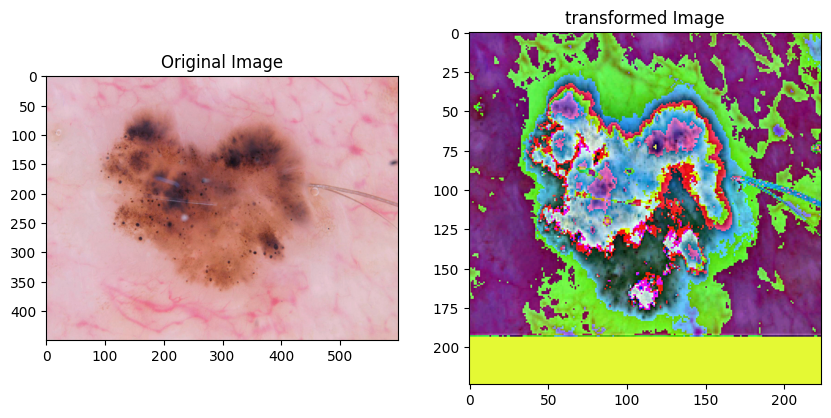

time: 929 ms (started: 2023-04-16 14:20:23 +00:00)


In [6]:
#show the image after applying transform, the picture looks distorted because we have applied normalization 
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the input image

image_path = '/ISIC - 2019/test/Basal cell carcinoma/ISIC_0027229.jpg'
input_image = Image.open(image_path)

# Apply the transforms function to the input image
randaugment_transform = randaug_transform(input_image)

# Convert the tensor back to an image for visualization
randaugment_transform = transforms.ToPILImage()(randaugment_transform)

# Display the original and transformed images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(input_image)
axs[0].set_title('Original Image')
axs[1].imshow(randaugment_transform)
axs[1].set_title('transformed Image')
plt.show()

In [7]:

from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import Subset

# Set the random seed for reproducibility
torch.manual_seed(42)

# Load and transform the data
train_dataset = datasets.ImageFolder(root='/ISIC - 2019/train', transform=randaug_transform)
test_dataset = datasets.ImageFolder(root='/ISIC - 2019/test', transform=auto_transforms)
val_dataset = datasets.ImageFolder(root='/ISIC - 2019/val', transform=auto_transforms)

# load the data and shuffle the training data
train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True, num_workers=4)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True,num_workers=4)

time: 47.3 ms (started: 2023-04-16 14:20:50 +00:00)


In [8]:
import timm 
#look up all the maxvit models in timm's library
maxvit_models = timm.list_models('*maxvit*')
maxvit_models

['maxvit_base_224',
 'maxvit_large_224',
 'maxvit_nano_rw_256',
 'maxvit_pico_rw_256',
 'maxvit_rmlp_nano_rw_256',
 'maxvit_rmlp_pico_rw_256',
 'maxvit_rmlp_small_rw_224',
 'maxvit_rmlp_small_rw_256',
 'maxvit_rmlp_tiny_rw_256',
 'maxvit_small_224',
 'maxvit_tiny_224',
 'maxvit_tiny_pm_256',
 'maxvit_tiny_rw_224',
 'maxvit_tiny_rw_256',
 'maxvit_xlarge_224']

time: 113 ms (started: 2023-04-16 14:21:02 +00:00)


In [9]:
import timm 
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

#create the model and change number of classes to 8
model = timm.create_model('maxvit_rmlp_small_rw_224', pretrained=True, num_classes=8)

# Set the random seed for reproducibility
torch.manual_seed(42)

#freeze the weights
for param in model.parameters():
    param.requires_grad = False
   
# unfreeze the last fc layer
for param in model.head.parameters():
    param.requires_grad = True


model.to(device)

# Set the random seed for reproducibility
torch.manual_seed(42)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights-maxx/maxvit_rmlp_small_rw_224_sw-6ef0ae4f.pth" to /root/.cache/torch/hub/checkpoints/maxvit_rmlp_small_rw_224_sw-6ef0ae4f.pth


time: 6.45 s (started: 2023-04-16 14:21:06 +00:00)


In [10]:
# Print a summary using torchinfo (uncomment for actual output)

model = model
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MaxxVit (MaxxVit)                                                 [32, 3, 224, 224]    [32, 8]              --                   Partial
├─Stem (stem)                                                     [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    └─Conv2d (conv1)                                             [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNormAct2d (norm1)                                     [32, 32, 112, 112]   [32, 32, 112, 112]   64                   False
│    │    └─Identity (drop)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    │    └─SiLU (act)                                            [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Conv2d (conv2)                                  

time: 2.41 s (started: 2023-04-16 14:21:13 +00:00)


In [11]:
# define optimizers and loss function and use the best hyperparameters found during the HP tuning in notebook: MaxViT_thesiscode_no_data_aug.ipynb

# Set the random seed for reproducibility
torch.manual_seed(42)

# Setup device agnostic code
criterion = nn.CrossEntropyLoss()
optimizer =  torch.optim.AdamW(model.parameters(), lr=0.002677105045743513)

time: 3.83 ms (started: 2023-04-16 14:21:22 +00:00)


In [12]:
#in this code we apply mixed precision training to allow for faster training and use early stopping to prevent overfitting 

# Set the random seed for reproducibility
torch.manual_seed(42)

import matplotlib.pyplot as plt
import torch
# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

# Lists to store the loss and accuracy values
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Train the model
num_epochs = 20
best_val_loss = float('inf')
patience = 5
for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for data in train_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()    # Scale the gradients
        scaler.step(optimizer)           # Update the model parameters
        scaler.update()                  # Update the scaler
        train_loss += loss.item() * inputs.size(0)
        train_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

    # Evaluate the model
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for data in valid_dataloader:
            inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

    # Print the results for this epoch
    train_loss /= len(train_dataloader.dataset)
    train_acc /= len(train_dataloader.dataset)
    val_loss /= len(valid_dataloader.dataset)
    val_acc /= len(valid_dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save the loss and accuracy values
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Check if the current validation loss is the best seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    # Stop training if the validation loss has not improved for `patience` epochs
    if epochs_since_improvement == patience:
        print(f"No improvement for {patience} epochs, stopping training.")
        break

Epoch 1/20: Train Loss: 1.0388, Train Acc: 0.6365, Val Loss: 0.9659, Val Acc: 0.6602
Epoch 2/20: Train Loss: 0.9537, Train Acc: 0.6601, Val Loss: 0.9380, Val Acc: 0.6717
Epoch 3/20: Train Loss: 0.9263, Train Acc: 0.6712, Val Loss: 0.9186, Val Acc: 0.6696
Epoch 4/20: Train Loss: 0.9222, Train Acc: 0.6724, Val Loss: 0.8977, Val Acc: 0.6796
Epoch 5/20: Train Loss: 0.9184, Train Acc: 0.6698, Val Loss: 0.8899, Val Acc: 0.6806
Epoch 6/20: Train Loss: 0.9111, Train Acc: 0.6728, Val Loss: 0.9121, Val Acc: 0.6733
Epoch 7/20: Train Loss: 0.9003, Train Acc: 0.6781, Val Loss: 0.9226, Val Acc: 0.6712
Epoch 8/20: Train Loss: 0.9017, Train Acc: 0.6781, Val Loss: 0.9071, Val Acc: 0.6880
Epoch 9/20: Train Loss: 0.9034, Train Acc: 0.6788, Val Loss: 0.9049, Val Acc: 0.6806
Epoch 10/20: Train Loss: 0.9049, Train Acc: 0.6786, Val Loss: 0.9165, Val Acc: 0.6743
No improvement for 5 epochs, stopping training.
time: 29min 25s (started: 2023-04-16 14:21:24 +00:00)


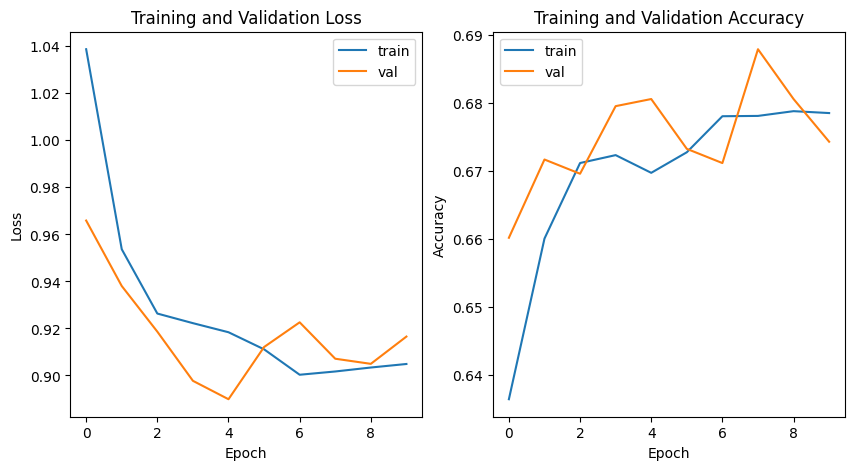

time: 239 ms (started: 2023-04-16 14:50:49 +00:00)


In [13]:
# Plot the validation and training loss and accuracy values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(val_losses, label='val')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(val_accs, label='val')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()
plt.show()

In [14]:
#evaluate on test set and calculate metrics, we are calculating macro f1 and roc-auc score, because of the heavily imbalanced dataset
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
import pandas as pd
import numpy as np

model.eval()
test_loss = 0.0
test_acc = 0.0
y_true = []
y_scores = []
y_pred = []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        test_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

        # Append predictions to lists
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

test_loss /= len(test_dataloader.dataset)
test_acc /= len(test_dataloader.dataset)

# Calculate metrics

import warnings
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(8)], digits=4)

conf_mat = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(np.array(pd.get_dummies(y_true)), y_scores, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Calculate other metrices
n_classes = conf_mat.shape[0]
sensitivity = 0
specificity = 0
for i in range(n_classes):
    tp = conf_mat[i,i]
    fn = np.sum(conf_mat[i,:]) - tp
    fp = np.sum(conf_mat[:,i]) - tp
    tn = np.sum(conf_mat) - tp - fn - fp
    sensitivity += tp / (tp + fn) * np.sum(conf_mat[i,:])
    specificity += tn / (tn + fp) * np.sum(conf_mat[i,:])
sensitivity /= np.sum(conf_mat)
specificity /= np.sum(conf_mat)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Loss: 0.8938
Test Accuracy: 0.6767
Sensitivity: 0.6767
Specificity: 0.7932
ROC-AUC: 0.8831
F1-score: 0.4643
Classification Report:
              precision    recall  f1-score   support

           0     0.4583    0.2933    0.3577        75
           1     0.6592    0.5880    0.6216       250
           2     0.4375    0.2069    0.2809       203
           3     0.0909    0.0909    0.0909        11
           4     0.7157    0.9420    0.8134       965
           5     0.6584    0.4444    0.5307       360
           6     0.5217    0.2857    0.3692        42
           7     0.8125    0.5417    0.6500        24

    accuracy                         0.6767      1930
   macro avg     0.5443    0.4241    0.4643      1930
weighted avg     0.6519    0.6767    0.6463      1930

time: 50.4 s (started: 2023-04-16 14:50:50 +00:00)


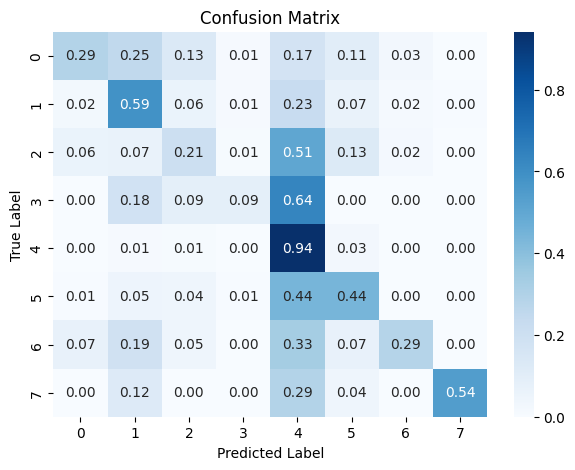

time: 255 ms (started: 2023-04-16 14:51:40 +00:00)


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels([str(i) for i in range(8)])
ax.yaxis.set_ticklabels([str(i) for i in range(8)])
plt.show()